In [243]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [245]:
# load the train.csv file into a pandas dataframe
df = pd.read_csv('TRAIN.csv')
df = pd.melt(df, id_vars=['Item code', 'Category', 'State'], var_name='date', value_name='sales')
df = df.dropna()

# Convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

df = df.sort_values('date').groupby(['Item code','Category','State','date'], as_index=False)
df = df.agg({'sales':['mean']})
df.columns = ['Item code','Category','State','date','sales']

print(df.shape)

(6463692, 5)


In [246]:
print('Min date from train set: %s' % df['date'].min().date())
print('Max date from train set: %s' % df['date'].max().date())

Min date from train set: 2017-01-29
Max date from train set: 2022-02-22


### convert the dates columns to a single column as 'date' with associated 'sales'

In [248]:
print(df.groupby(['Item code','Category','State'])['sales'].sum().sort_values(ascending=False).head(10))

print(df.shape)

Item code           Category        State
ANTIDIABETIC_348    ANTIDIABETIC    MH       22442.0
ANTIDIABETIC_371    ANTIDIABETIC    MH       21971.0
ANTIBIOTIC_218      ANTIBIOTIC      MH       21742.0
ANTIBIOTIC_085      ANTIBIOTIC      TN       20325.0
                                    MH       19709.0
CARDIOVASCULAR_521  CARDIOVASCULAR  UP       19368.0
CARDIOVASCULAR_334  CARDIOVASCULAR  UP       18755.0
ANTIDIABETIC_268    ANTIDIABETIC    MH       18191.0
ANTIBIOTIC_018      ANTIBIOTIC      MH       17969.0
CARDIOVASCULAR_234  CARDIOVASCULAR  UP       17748.0
Name: sales, dtype: float64
(6463692, 5)


In [249]:
# select the most popular item code, category and state combination by sales
df_copy = df[(df['Item code'] == 'ANTIDIABETIC_348') & ((df['State'] == 'MH'))]
print(df_copy.shape)

(1851, 5)


In [250]:
df_copy= df_copy.drop(['Item code', 'Category', 'State'], axis=1)

In [187]:
train = df_copy[(df_copy['date'] <= '2022-01-25')]
test = df_copy[(df_copy['date'] >= '2022-01-26')]
print(train.shape)
print(test.shape)

# index dataframe without any column
train = train.reset_index()
test = test.reset_index()

(1823, 2)
(28, 2)


<Axes: xlabel='date'>

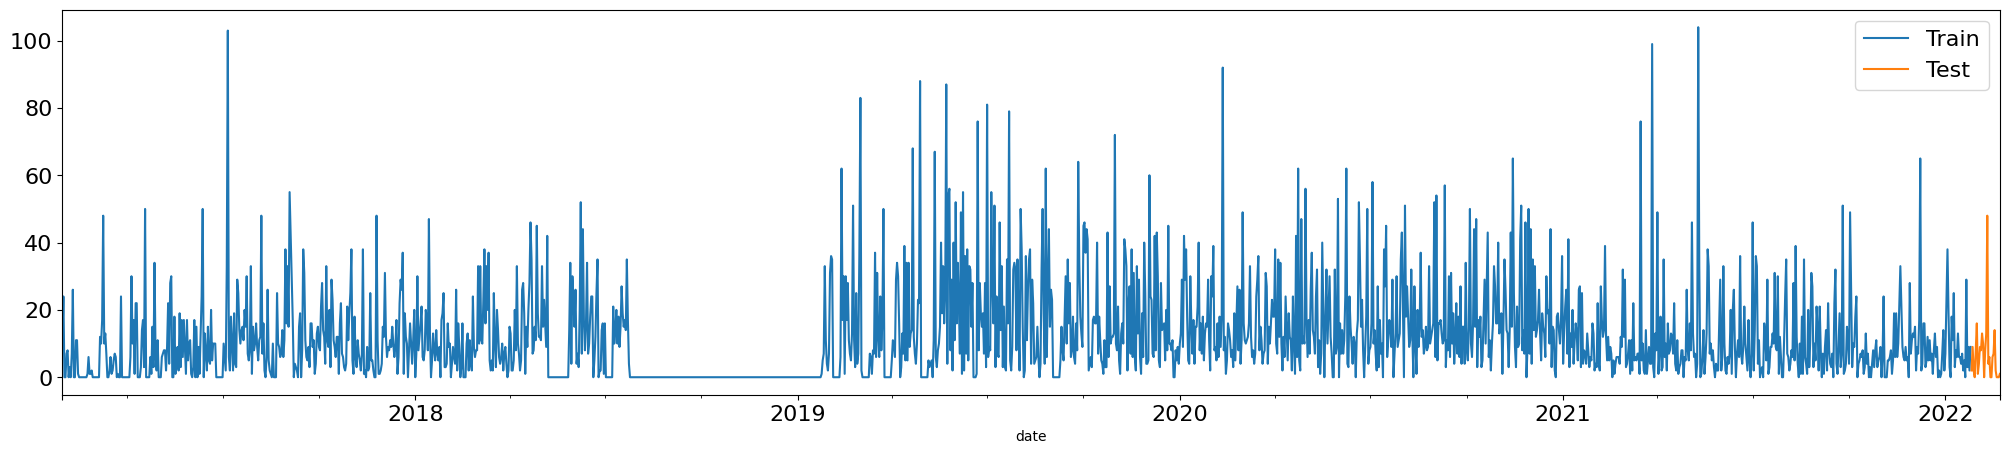

In [252]:
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
params = {'legend.fontsize': 16,'legend.handlelength': 2}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(25,5))
train.plot(x='date',y='sales',label='Train',ax=ax)
test.plot(x='date',y='sales',label='Test',ax=ax)

In [253]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [254]:
adf_test(train['sales'],title='sales')

Augmented Dickey-Fuller Test: sales
ADF test statistic     -5.851279e+00
p-value                 3.584488e-07
# lags used             1.500000e+01
# observations          1.807000e+03
critical value (1%)    -3.433974e+00
critical value (5%)    -2.863141e+00
critical value (10%)   -2.567622e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


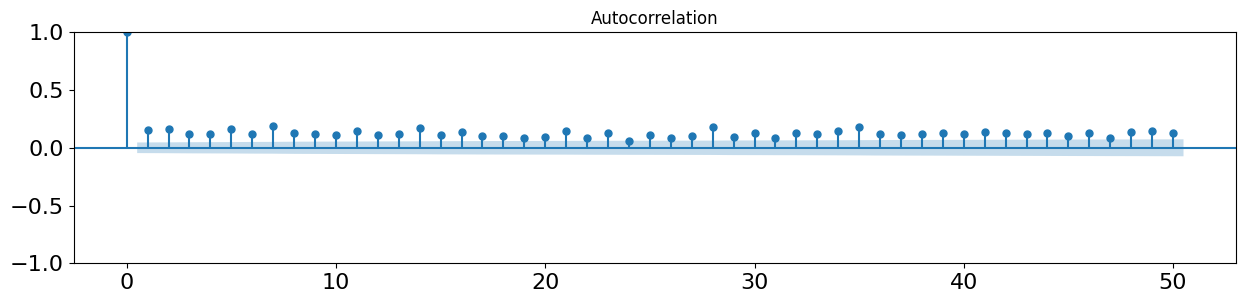

In [256]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(15,3))
plot_acf(train['sales'].tolist(), lags=50, ax=ax)
plt.show()

In [257]:
import pandas as pd
predictions = pd.DataFrame()
predictions['date'] = test['date']

RMSE for Simple Exponential Smoothing: 9.3082


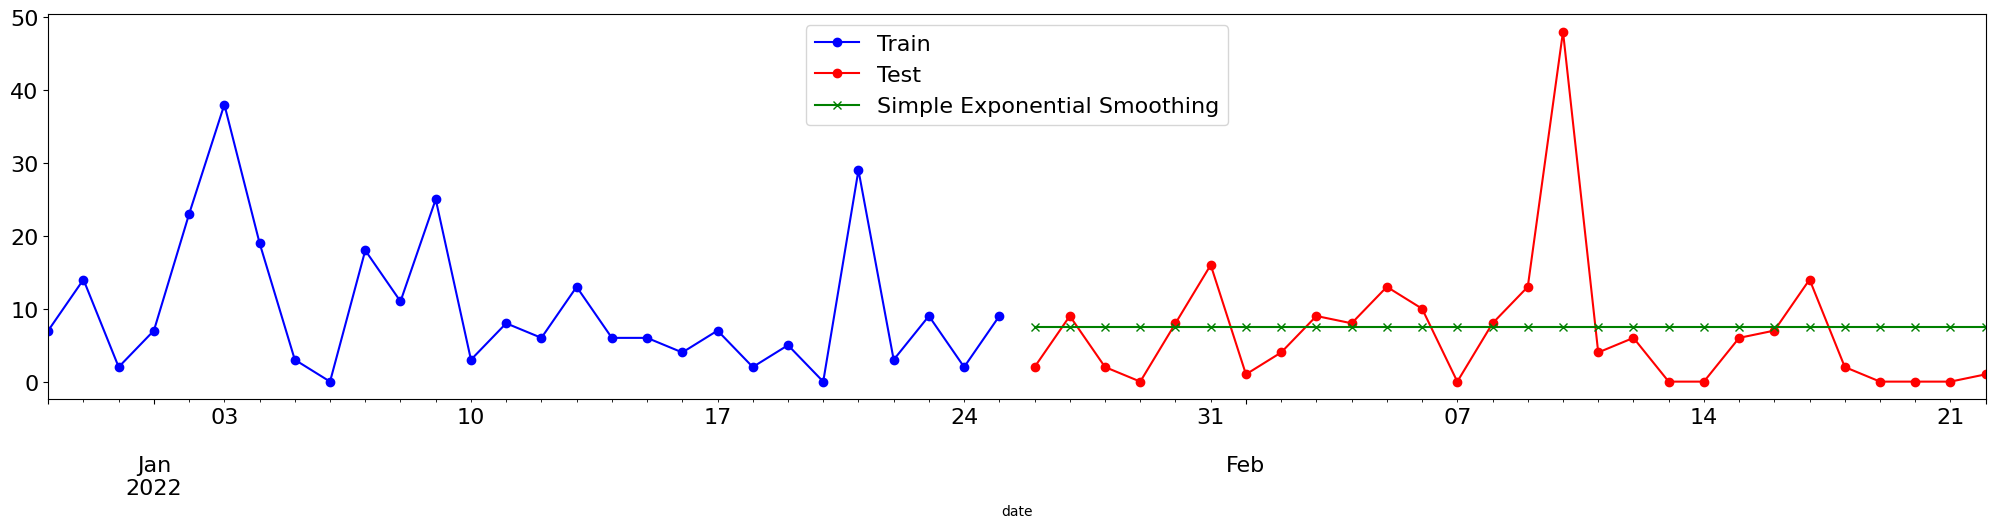

In [259]:
import time
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

t0 = time.time()
model_name='Simple Exponential Smoothing'
span = 7
alpha = 2/(span+1)
#train
simpleExpSmooth_model = SimpleExpSmoothing(train['sales']).fit(smoothing_level=alpha,optimized=False)
t1 = time.time()-t0
#predict
predictions[model_name] = simpleExpSmooth_model.forecast(28).values
fig, ax = plt.subplots(figsize=(25,5))
train[-28:].plot(x='date',y='sales',label='Train',ax=ax, marker='o', color='blue')
test.plot(x='date',y='sales',label='Test',ax=ax, marker='o', color='red');
predictions.plot(x='date',y=model_name,label=model_name,ax=ax, marker='x', color='green');
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['sales']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

# stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

RMSE for Triple Exponential Smoothing: 9.6712


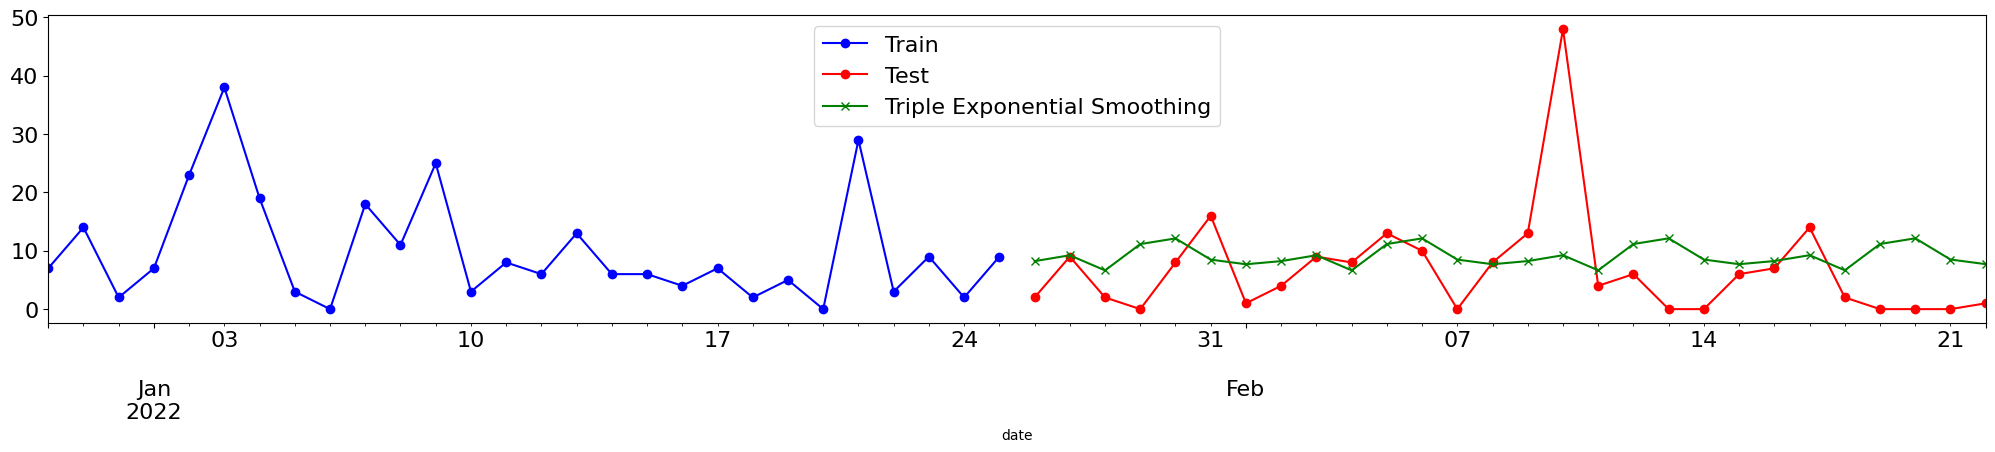

In [260]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

t0 = time.time()
model_name='Triple Exponential Smoothing'
#train
tripleExpSmooth_model = ExponentialSmoothing(train['sales'],trend='add',seasonal='add',seasonal_periods=7).fit()
t1 = time.time()-t0
#predict
predictions[model_name] = tripleExpSmooth_model.forecast(28).values
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='sales',label='Train',ax=ax, marker='o', color='blue')
test.plot(x='date',y='sales',label='Test',ax=ax, marker='o', color='red');
predictions.plot(x='date',y=model_name,label=model_name,ax=ax, marker='x', color='green');
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['sales']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

In [261]:
from pmdarima import auto_arima
t0 = time.time()
model_name='SARIMA'
sarima_model = auto_arima(train['sales'], start_p=0, start_q=0,
                          max_p=20, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=12345,
                          out_of_sample_size=28,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=15759.407, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=15790.168, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=15247.696, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=14630.014, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=15788.168, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=14635.831, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=14608.304, Time=1.04 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=14629.313, Time=0.40 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=14610.153, Time=1.84 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=14610.148, Time=2.73 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=14628.823, Time=1.15 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=14628.015, Time=0.90 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=14612.283, Time=2.24 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=14608.514, Time=2.01 sec
 ARIMA(0,1,2)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1823
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -7299.137
Date:                           Sat, 02 Mar 2024   AIC                          14606.273
Time:                                   12:56:50   BIC                          14628.304
Sample:                                        0   HQIC                         14614.401
                                          - 1823                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9716      0.006   -173.871      0.000      -0.983      -0.961
ar.S.L7        0.9264      0.031     29.709      0.000       0.865       0.987
ma.S.L7       -0.8752      0.040    -21.998      0.000      -0.953      -0.797
sigma2       176.3751      2.718     64.897      0.000     171.048     181.702
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):              5401.50
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             2.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA: 9.7206


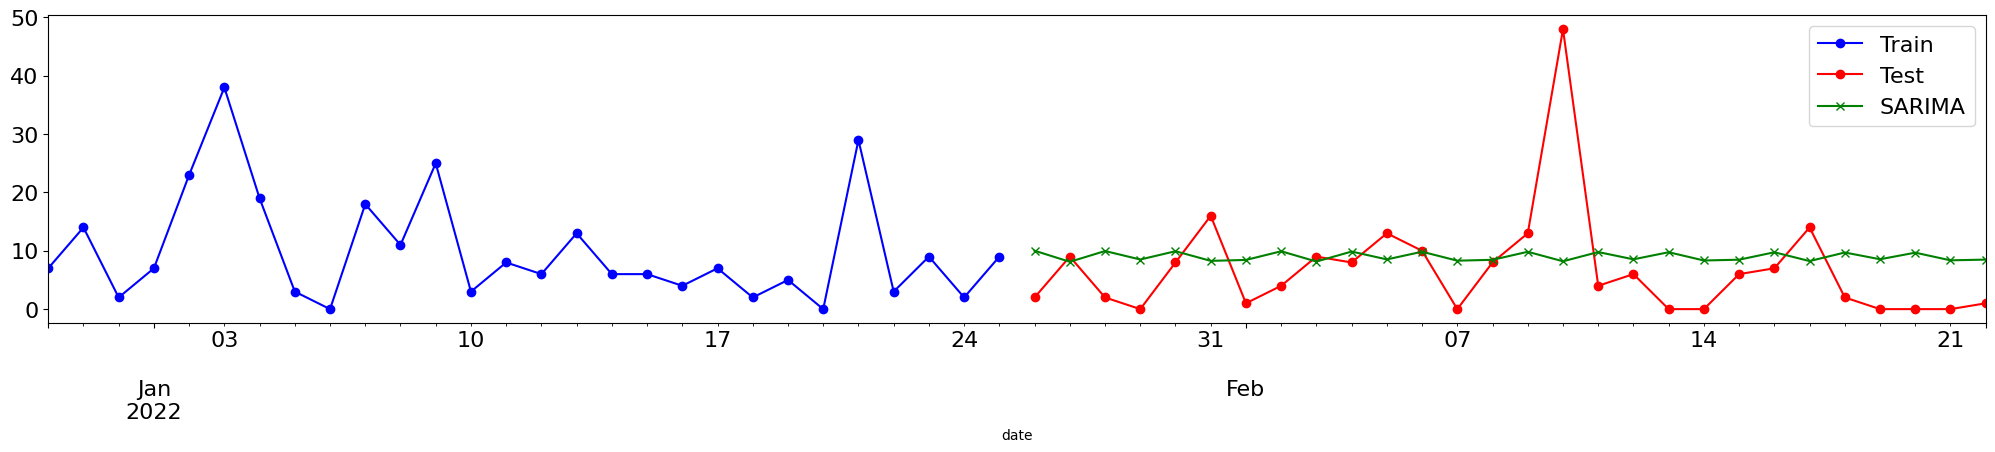

In [262]:
sarima_model.fit(train['sales'])
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='sales',label='Train',ax=ax, marker='o', color='blue')
test.plot(x='date',y='sales',label='Test',ax=ax, marker='o', color='red');
predictions.plot(x='date',y=model_name,label=model_name,ax=ax, marker='x', color='green');
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['sales']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

# stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [313]:
from statsforecast import StatsForecast
from statsforecast.models import ADIDA, CrostonClassic, IMAPA, TSB

model_name = "CrostonClassic"
train_copy = train.copy()
train_copy = train_copy.rename(columns={'date': 'ds', 'sales': 'y','index':'unique_id'})
train_copy = train_copy.reset_index()
# train_copy.head()
model = StatsForecast(models=[CrostonClassic()], freq='D', n_jobs=-1)

/phr-mental-chat/makind/lib/python3.11/site-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


Forecast:   0%|          | 0/38 [00:00<?, ?it/s]104.08it/s]

Forecast:   3%|▎         | 1/38 [00:04<03:00,  4.87s/it]]

Forecast: 100%|██████████| 38/38 [00:04<00:00,  7.90it/s]

Forecast: 100%|██████████| 38/38 [00:04<00:00,  7.68it/s]

Forecast: 100%|██████████| 38/38 [00:04<00:00,  7.64it/s]

Forecast: 100%|██████████| 38/38 [00:04<00:00,  7.66it/s]

Forecast: 100%|██████████| 38/38 [00:05<00:00,  7.30it/s]
/phr-mental-chat/makind/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


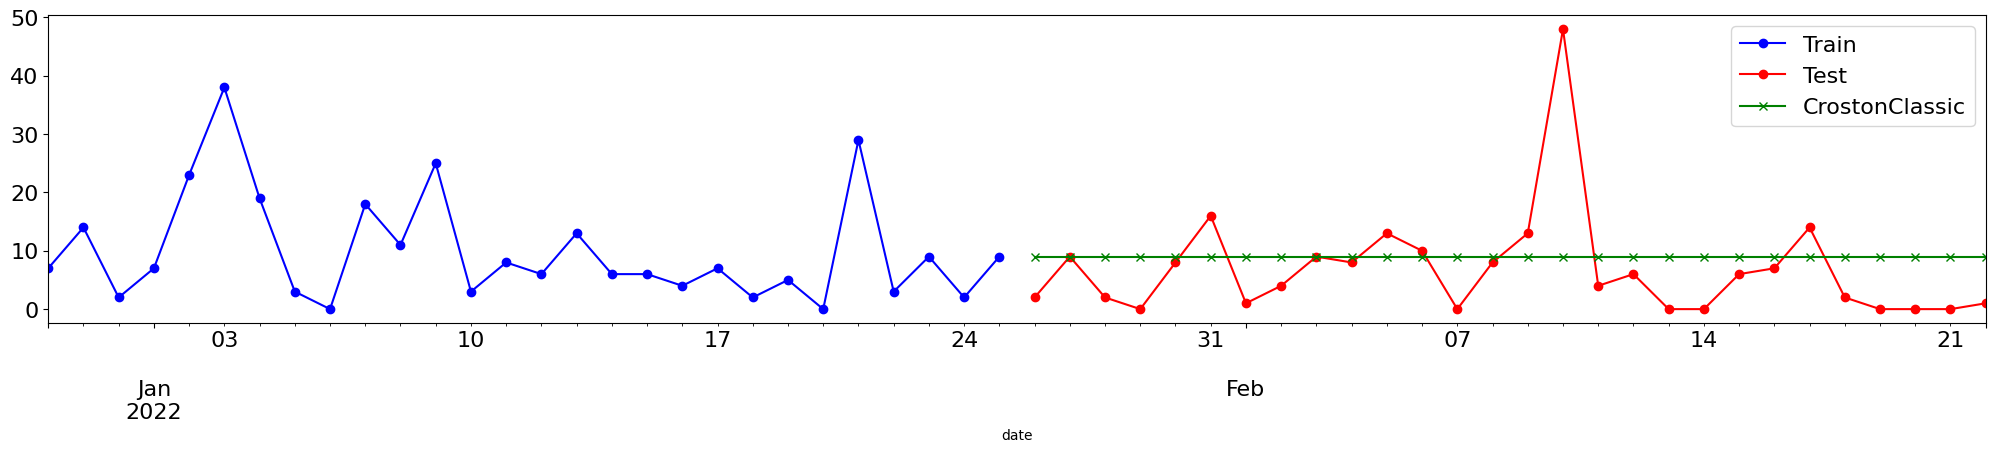

In [315]:
predictions['CrostonClassic'] = model.forecast(h=28)['CrostonClassic'].values[-28:]
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='date',y='sales',label='Train',ax=ax, marker='o', color='blue')
test.plot(x='date',y='sales',label='Test',ax=ax, marker='o', color='red');
predictions.plot(x='date',y=model_name,label=model_name,ax=ax, marker='x', color='green');

In [316]:
def wmape(y_true, y_pred):
    total = 0
    count = 0
    for i in range(0, len(y_true)):
        y_true_chunk = y_true[i]
        y_pred_chunk = y_pred[i]
        total += np.abs(y_true_chunk - y_pred_chunk)
        count += np.abs(y_true_chunk)
    return 100 * total / count

def smape(y_true, y_pred):
    total = 0
    n = len(y_true)
    for i in range(n):
        total += 2 * np.abs(y_pred[i] - y_true[i]) / (np.abs(y_true[i]) + np.abs(y_pred[i]))
    return 100 * total / n

In [318]:
print(wmape(test['sales'], predictions["CrostonClassic"]))
print(wmape(test['sales'], predictions["Simple Exponential Smoothing"]))
print(wmape(test['sales'], predictions["Triple Exponential Smoothing"]))
print(wmape(test['sales'], predictions["SARIMA"]))

94.76439790575917
86.99067491302816
95.28312821956987
97.71451164733706
